<a href="https://colab.research.google.com/github/Lucile-S/ART_project/blob/main/MNIST_cWGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

NO batch norm  for critic  WGAN !!!!!

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/4.%20WGAN-GP


https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f
https://github.com/alex-lechner/PyTorch-GAN
https://towardsdatascience.com/gangogh-creating-art-with-gans-8d087d8f74a1
https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
https://www.linkedin.com/pulse/conditional-generative-adversarial-network-cgan-chinese-wang/

https://github.com/rkjones4/GANGogh

https://github.com/Adi-iitd/AI-Art
https://github.com/robbiebarrat/art-DCGAN

https://levelup.gitconnected.com/painting-portraits-using-gans-with-pytorch-afeb69b1c5a1

http://cs231n.stanford.edu/reports/2017/pdfs/311.pdf


https://github.com/znxlwm/pytorch-Conditional-image-to-image-translation/blob/master/train.py

https://github.com/ibrahimjelliti/Deeplearning.ai-GAN-Specialization-Generative-Adversarial-Networks/blob/master/1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%204/C1W4A_Build_a_Conditional_GAN.ipynb


https://blog.jovian.ai/generating-art-with-gans-352ceef3d51f

# Packages 

In [ ]:
! pip install --upgrade --quiet neptune-client==0.9.5
! pip install torchsummary

     |████████████████████████████████| 211 kB 14.5 MB/s 
     |████████████████████████████████| 829 kB 25.2 MB/s 
     |████████████████████████████████| 68 kB 9.1 MB/s 
     |████████████████████████████████| 170 kB 64.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 67 kB 7.2 MB/s 
     |████████████████████████████████| 129 kB 42.5 MB/s 


In [ ]:
import os
from glob import iglob 
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import copy
import urllib
import time
from datetime import datetime
import collections 
from tqdm import tqdm
import torch
import json
import torchvision
import random
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import neptune.new as neptune
%matplotlib inline

pd.set_option('max_colwidth', None)
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def check_for_CUDA():
	"""Check whether CUDA is available
	Parameters
	----------
	target : object
		An object which contains attribute `config`
	"""

	if torch.cuda.is_available():
		print("CUDA is available!")
		print("Using {}".format(torch.device("cuda:0")))
	else:
		print("Cuda is NOT available, running on CPU.")
		print(torch.device("cpu"))

	
# check pytorch version and GPU
print(torch.__version__)
check_for_CUDA()

1.9.0+cu102
CUDA is available!
Using cuda:0


In [ ]:
# -- To ensure reproductibility 
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
#Intialise a random number generator
rng = np.random.default_rng(seed)

def _init_fn(worker_id):
  np.random.seed(int(seed))

# Mount DRIVE 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/MyDrive/ /mydrive

In [ ]:
%cd mydrive

[Errno 2] No such file or directory: 'mydrive'
/content


In [ ]:
!ls /mydrive/GAN

Data  generated  logs  Models


# Usefull Functions

In [ ]:
def open_json_file(json_path):
    # Opening JSON file
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data 


def MakeDir(DIR:str) -> None:
    try:
        if not os.path.exists(DIR):
            os.makedirs(DIR)
    except OSError as err:
        print(err)
        pass

def dict_to_json(dictionary:dict, json_path:str) -> None:
    with open(json_path, "w", encoding='utf-8') as outfile: 
        json.dump(dictionary, outfile, indent=4)
        #print(f'json file saved in {json_path}')


def show_batch(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    try: 
      image_unflat = image_tensor.detach().cpu()
    except: 
      image_unflat = image_tensor
      
    plt.figure(figsize = (12,12))
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


def ImgChannelNb(image_path:str, show=False):
    # -- with cv2
    # print(cv2.imread(image_test, cv2.IMREAD_UNCHANGED).shape)
    # -- with Image (PIL)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if image.ndim ==2:
        channels =1
    else:
        channels = image.shape[-1]
    if show:
      print(f'Image has: {channels} channel(s)')
      print(f'Image size is : {image.shape}')
    return channels, image.shape


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)



def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

# DATA
postgre : https://docs.postgresql.fr/12/tutorial-createdb.html


## load data



In [ ]:
%ls gdrive/MyDrive/GAN/Data/

amedeo-modigliani/      gustav-klimt/                   pierre-auguste-renoir/
arnold-bocklin/         henri-matisse/                  piet-mondrian/
artemisia-gentileschi/  henri-rousseau/                 rembrandt/
Artists.csv             john-james-audubon/             sandro-botticelli/
claude-monet/           joseph-mallord-william-turner/  theophile-steinlen/
david-burliuk/          katsushika-hokusai/             vassily-kandinsky/
edward-hopper/          pablo-picasso/                  vincent-van-gogh/
ernst-ludwig-kirchner/  Paintings.csv                   zdzislaw-beksinski/


In [ ]:
from torchvision import datasets

BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
transformation = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ])

#dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
dataset_DIR='gdrive/MyDrive/GAN/Data/mnist'
MakeDir(dataset_DIR)
dataset = datasets.MNIST(root=dataset_DIR, transform=transformation, download=True)
#dataset = datasets.ImageFolder(root=dataset_DIR, transform=transformation)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
sample_dir = os.path.join(DIR,'generated','Wcgan')
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
len(dataset)
print('')
len(dataloader)

60000

938

## show 1 batch

tensor([5, 6, 4, 2, 9, 9, 4, 3, 4, 2, 6, 3, 9, 8, 2, 4, 2, 2, 3, 7, 8, 5, 7, 0,
        8, 5, 5, 1, 9, 7, 8, 6, 8, 1, 8, 3, 3, 6, 5, 6, 8, 1, 7, 9, 6, 0, 3, 1,
        7, 3, 1, 1, 7, 8, 3, 9, 4, 9, 6, 0, 4, 9, 1, 2])
torch.Size([64, 1, 64, 64])


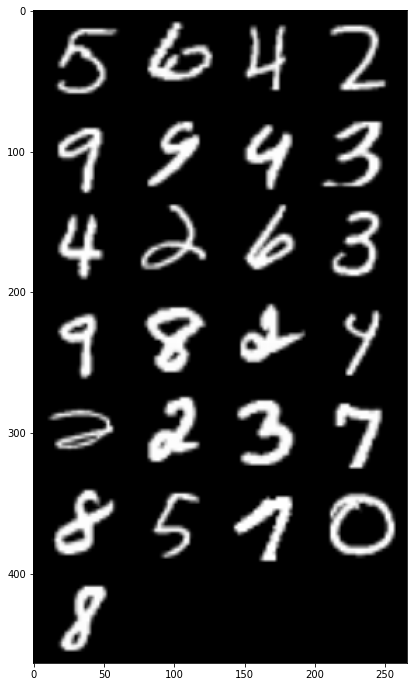

In [ ]:
stop = 0
for i, (images, labels) in  enumerate(dataloader):
  print(labels)
  print(images.shape)
  show_batch(images, num_images=25, size=(1, 64, 64), nrow=4, show=True)
  if i == stop:
    break

# MODEL ARCHITECTURE 

## Descriminator

In [ ]:
# from https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%204/C1W4A_Build_a_Conditional_GAN_original.ipynb
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(im_chan, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.make_disc_block(hidden_dim, hidden_dim * 2,  kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4,  kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim*4, hidden_dim * 8,  kernel_size=4, stride=2, padding=1),
            self.make_disc_block(hidden_dim*8,2, kernel_size=4, stride=1, padding=0,final_layer=True),
        )


    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.InstanceNorm2d(output_channels, affine=True),
                nn.LeakyReLU(0.2),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)






## Generator

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network |  Input: N x channels_noise x 1 x 1
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 16, kernel_size=4, stride=1,padding=0),
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim*2, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim*2, im_chan, kernel_size=4,stride=2, padding=1,final_layer=True),
        ) # => Output: N x channels_img x hidden_dim x hidden_dim

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

 

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

# Class Input
In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you

## one hot labels

In [ ]:
n_classes  = 10 
print(f'n_classes parameter : {n_classes}')

n_classes parameter : 10


In [ ]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

tensor([9, 9, 1, 4, 8, 5, 1, 6, 4, 1, 1, 1, 9, 8, 6, 2, 6, 9, 6, 0, 0, 4, 8, 9,
        4, 0, 1, 9, 0, 0, 9, 8, 0, 2, 8, 8, 4, 4, 6, 5, 2, 8, 1, 7, 9, 8, 6, 1,
        7, 7, 0, 5, 2, 6, 5, 4, 6, 5, 3, 7, 0, 6, 1, 7])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0,

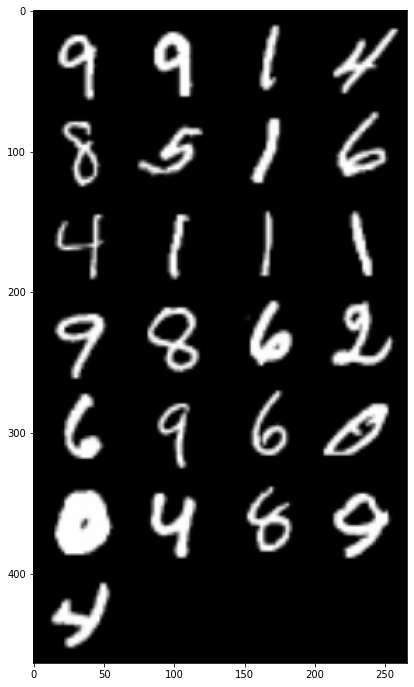

In [ ]:
# test 
stop = 0
for i, (images, labels) in  enumerate(dataloader):
  print(labels)
  one_hot_labels = get_one_hot_labels(labels,n_classes)
  print(one_hot_labels)
  show_batch(images, num_images=25, size=(3, 64, 64), nrow=4, show=True)
  if i == stop:
    break

##  Concatenate the one-hot class vector to the noise vector

Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats. Again, you can look to the PyTorch library for help.

In [ ]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

torch.Size([64, 10])
torch.Size([64, 1])
torch.Size([64, 11])


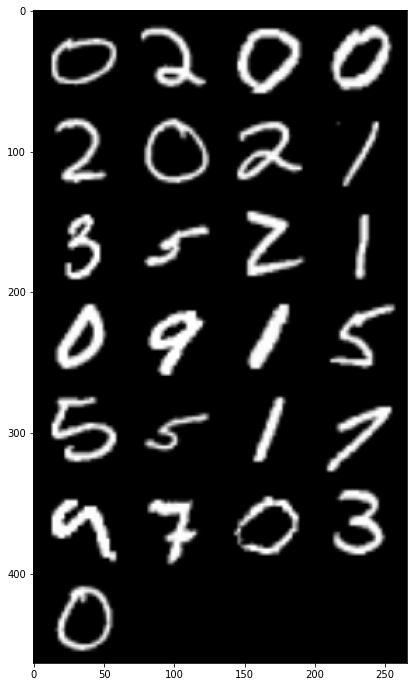

In [ ]:
stop = 0
for i, (images, labels) in enumerate(dataloader):
  one_hot_labels = get_one_hot_labels(labels,n_classes)
  print(one_hot_labels.shape)
  noise_vector = torch.randn(len(one_hot_labels), 1)
  print(noise_vector.shape)
  combined_vectors = combine_vectors(noise_vector, one_hot_labels)
  print(combined_vectors.shape)
  show_batch(images, num_images=25, size=(1, 64, 64), nrow=4, show=True)

  if i == stop:
    break

# Training

## parameters

In [ ]:
# -- initialize the device
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

criterion = nn.BCEWithLogitsLoss() # This loss combines a Sigmoid layer and the BCELoss in one single class
n_epochs_start = 0
n_epochs = n_epochs_start +150
z_dim = 100
display_step = 500
batch_size = 64
lr = 0.0005
beta_1 = 0.5
beta_2 = 0.9
hidden_dim=64
c_lambda = 10
crit_repeats = 5

#model_save_DIR = os.path.join(DIR,'Models')

# D_lr = 2e-4
# G_lr = 1e-4
Channel_img = 1
input_shape = (Channel_img, 64, 64)
n_classes = 10


## Input Dimension


Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [ ]:
def get_input_dimensions(z_dim, input_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = input_shape[0] + n_classes
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, input_shape, n_classes)
print(f'Generator input dim (dim noise + n_classes): {generator_input_dim}')
print(f'Discriminator input channels (channel nb + n_classes): {discriminator_im_chan}')

Generator input dim (dim noise + n_classes): 110
Discriminator input channels (channel nb + n_classes): 11


## GENERATOR and DISCRIMNATOR INSTANCES and optimizers

In [ ]:
gen = Generator(input_dim=generator_input_dim, im_chan=Channel_img, hidden_dim=64).to(device)
crit = Discriminator(im_chan=discriminator_im_chan).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1,beta_2))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1,beta_2))

# initializate optimizer from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/4.%20WGAN-GP/train.py

In [ ]:
print_network(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(110, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): C

In [ ]:
print_network(crit)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Sequential(
      (0): Conv2d(512, 2, kernel_size=(4, 4), stride=(1, 1))
    )
  )
)
Total number of parameters:

## Weights initialization

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)



In [ ]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"



### if checkpoint

In [ ]:
!ls gdrive/MyDrive/GAN/Models

2021_07_15_GAN_v1_235_latest.pkl  2021_07_24_GAN_v1_400_latest.pkl
2021_07_15_GAN_v1_245_latest.pkl  2021_07_24_GAN_v1_410_latest.pkl
2021_07_24_GAN_v1_250_latest.pkl  2021_07_24_GAN_v1_420_latest.pkl
2021_07_24_GAN_v1_260_latest.pkl  2021_07_24_GAN_v1_438_latest.pkl
2021_07_24_GAN_v1_270_latest.pkl  2021_07_24_GAN_v1_440_latest.pkl
2021_07_24_GAN_v1_280_latest.pkl  2021_07_24_GAN_v1_467_latest.pkl
2021_07_24_GAN_v1_290_latest.pkl  2021_07_24_GAN_v1_468_latest.pkl
2021_07_24_GAN_v1_300_latest.pkl  2021_07_24_GAN_v1_469_latest.pkl
2021_07_24_GAN_v1_310_latest.pkl  2021_07_24_GAN_v1_470_latest.pkl
2021_07_24_GAN_v1_326_latest.pkl  2021_07_24_GAN_v1_480_latest.pkl
2021_07_24_GAN_v1_329_latest.pkl  2021_07_24_GAN_v1_499_latest.pkl
2021_07_24_GAN_v1_330_latest.pkl  2021_07_26_WcGAN_v1_70_latest.pkl
2021_07_24_GAN_v1_390_latest.pkl  2021_07_26_WcGAN_v1_80_latest.pkl


In [ ]:
#ckpt_path = 'gdrive/MyDrive/GAN/Models/' + '2021_07_24_GAN_v1_250_latest.pkl'
ckpt_path  =None
if ckpt_path is not None:
    ckpt = torch.load(ckpt_path)
    gen.load_state_dict(ckpt['gen_state_dict'])
    crit.load_state_dict(ckpt['disc_state_dict'])
    gen_opt.load_state_dict(ckpt['gen_optimizer_state_dict'])
    crit_opt.load_state_dict(ckpt['disc_optimizer_state_dict'])


gen = gen.apply(weights_init)
crit= crit.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:

- Tell that to the generator, so that it knows it should be generating a "1"
- Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake
There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). You will need to fill in the code to get the gradient wherever you see None. There is a test function in the next block for you to test your solution.


The second function you need to complete is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

Again, you will need to fill in the code wherever you see None. There are hints below that you can view if you need help and there is a test function in the next block for you to test your solution.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    BATCH_SIZE, C, H, W = real.shape
    # Mix the images together
    # epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

 

In [ ]:
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((64, 11, 64, 64))
print("Success!")

Success!


In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(gradient.shape[0], -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####
    return penalty


  

In [ ]:
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    #print(good_gradient)
    good_gradient_penalty = gradient_penalty(good_gradient)
    print(good_gradient_penalty)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 11, 64, 64))
print("Success!")

tensor(4.6608e-08)


AssertionError: ignored

# Losses

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -1. * torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [ ]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Success!")

Success!


In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss
  
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


## To save  Fake samples 

In [ ]:
# sample_dir = os.path.join(DIR,'generated')
# os.makedirs(sample_dir, exist_ok=True)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


# def save_samples(index, fixed_noise,sample_dir = sample_dir, resize_size=128, show=True):
#     fake_images = gen(fixed_noise)
#     fake_fname = 'Wcgan-generated-images-{0:0=4d}.png'.format(index)
#     save_image(denorm(transforms.Resize(resize_size)(fake_images)).clamp(0, 1), os.path.join(sample_dir, fake_fname), nrow=8)
#     print('Saving', fake_fname)
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(denorm(fake_images.detach().cpu()), nrow=8).permute(1, 2, 0).squeeze())
#         plt.show()


In [ ]:
len(dataloader)

938

### fixed_noise_test


In [ ]:
#fixed_labels  = torch.tensor(list(np.arange(0,n_classes))*3).to(device)
#fixed_noise = get_noise(fixed_labels.shape[0], z_dim, device=device)
#print(fixed_labels.shape)
#print(fixed_noise.shape)

#combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))
#noise_and_labels = combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))

fixed_labels  = torch.tensor(list(np.arange(0,n_classes))*3).to(device)
fixed_noise = get_noise(fixed_labels.shape[0],z_dim, device=device)
print(fixed_labels.shape)
print(fixed_noise.shape)


torch.Size([30])
torch.Size([30, 100])


## Train

Epoch 0 | Step 500: Generator loss: 40.91776641345024, discriminator loss: -41.55561451807021
--real images ---


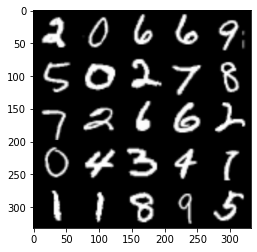

--fake images ---


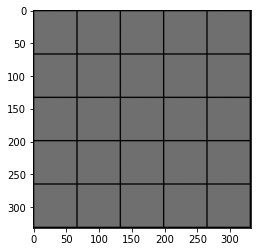

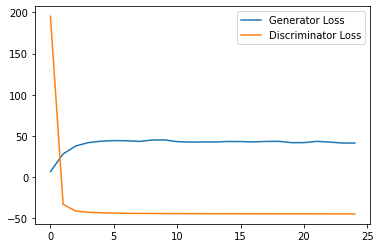

Epoch 1 | Step 1000: Generator loss: 40.18784352874756, discriminator loss: -44.71066692810066
--real images ---


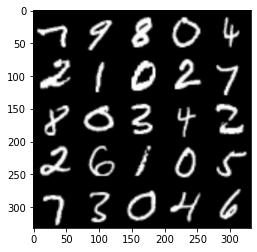

--fake images ---


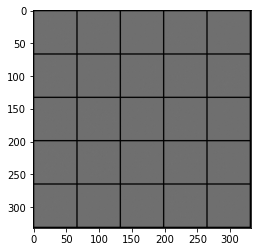

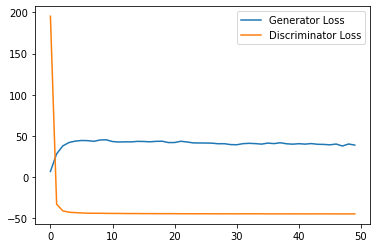

Epoch 1 | Step 1500: Generator loss: 38.61967539978027, discriminator loss: -44.81765177001956
--real images ---


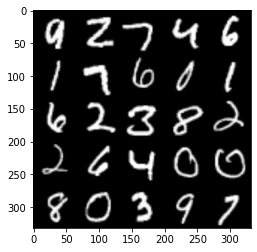

--fake images ---


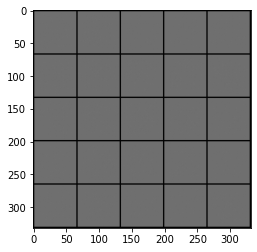

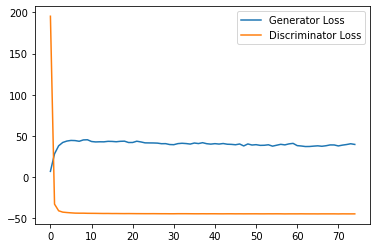

Epoch 2 | Step 2000: Generator loss: 41.012048332214356, discriminator loss: -44.877816696167045
--real images ---


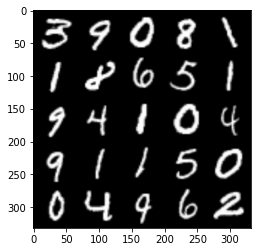

--fake images ---


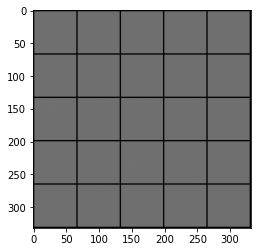

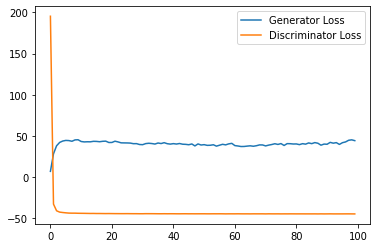

Epoch 2 | Step 2500: Generator loss: 42.75084169769287, discriminator loss: -44.91681993255617
--real images ---


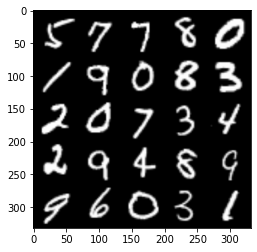

--fake images ---


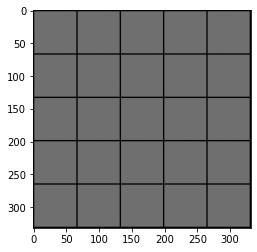

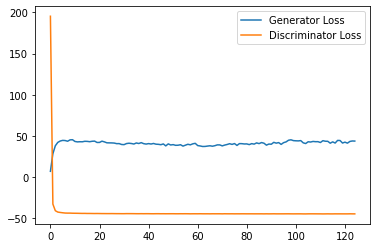

Epoch 3 | Step 3000: Generator loss: 44.10043524932861, discriminator loss: -44.92910986938476
--real images ---


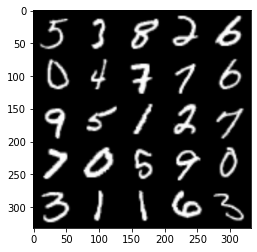

--fake images ---


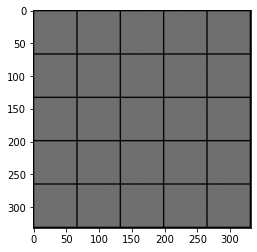

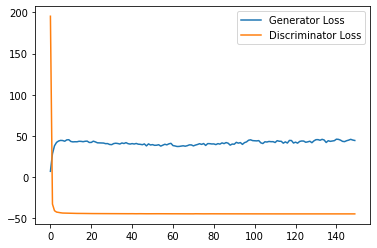

KeyboardInterrupt: ignored

In [ ]:
date = datetime.now().strftime("%Y_%m_%d")
cur_step = 0
generator_losses = []
critic_losses = []

# writer  =  SummaryWriter(os.path.join(DIR,'logs','Wcgan'))
# writer_real = SummaryWriter(os.path.join(DIR,'logs','Wcgan','real'))
# writer_fake = SummaryWriter(os.path.join(DIR,'logs','Wcgan','fake'))

fake_image_and_labels = False
real_image_and_labels = False

for epoch in range(n_epochs_start, n_epochs):
    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        # --- label encoding 
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes) # [Batch_size x n_classes]
        image_one_hot_labels = one_hot_labels[:, :, None, None] 
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, input_shape[1], input_shape[2]) # [Batch_size x n_classes x 64 x 64] | for ex if label = 21 for image #0, the 21th 64*64 "image' will be full of 1 whereas the other one full of 0 

        mean_iteration_critic_loss = 0

        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            # discriminator prediction | input = image + labels
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
                                                    
            crit_fake_pred = crit(fake_image_and_labels.detach())
            crit_real_pred = crit(real_image_and_labels)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real_image_and_labels, fake_image_and_labels.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()

        critic_losses += [mean_iteration_critic_loss]
        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        noise_and_labels_2 = combine_vectors(fake_noise_2, one_hot_labels)
        fake_2 = gen(noise_and_labels_2)
        fake_image_and_labels_2 = combine_vectors(fake_2, image_one_hot_labels)
        crit_fake_pred = crit(fake_image_and_labels_2.detach())
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch} | Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {crit_mean}")
            print('--real images ---')
            show_tensor_images(real)
            print('--fake images ---')
            show_tensor_images(fake)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

            # # -- write to writer
            # writer.add_scalar("gen_loss", gen_mean,cur_step)
            # writer.add_scalar("critic_loss", crit_mean, cur_step)
            
            # -- save image 
            with torch.no_grad():
                noise_and_labels_fixed = combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))
                fake = gen(noise_and_labels_fixed)
                img_grid_real = torchvision.utils.make_grid(
                        real, normalize=True)
                img_grid_fake = torchvision.utils.make_grid(
                    fake, normalize=True)
                # writer_real.add_image("Real", img_grid_real, global_step=cur_step)
                # writer_fake.add_image("Fake", img_grid_fake, global_step=cur_step)

        cur_step += 1

    # -- save the model at the end of the epoch 
    if epoch % 10 == 0 and epoch > 0:
        torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': crit.state_dict(),
        'gen_optimizer_state_dict': gen_opt.state_dict(),
        'disc_optimizer_state_dict': crit_opt.state_dict(),
        }, os.path.join(model_save_DIR, f'{date}_WcGAN_v1_{epoch}_latest.pkl'))

        print('saving images generated with fixed noise')
        noise_and_labels_fixed = combine_vectors(fixed_noise, get_one_hot_labels(fixed_labels, n_classes))
        save_samples(epoch, noise_and_labels_fixed,sample_dir = sample_dir, resize_size=128, show=True)
        print('------------------------------------------------------------------------------------')

        